# Machine learning Walmart sales prediction
In this project, I will build a <b>machine learning model to predict Walmart sales</b>. It is a <b>supervised learning (labeled training set) regression task</b>, with a <b>continuous target, the weekly sales amount</b>.

I'll use the following <b>pipeline:</b><br>

<b>1. Define the business problem.</b><br>
<b>2. Collect the data and get a general overview of it.</b><br>
<b>3. Split the data into train and test sets.</b><br>
<b>4. Explore the data (exploratory data analysis).</b><br>
<b>5. Data cleaning and preprocessing.</b><br>
<b>6. Model training, comparison, selection and tuning.</b><br>
<b>7. Final production model testing and evaluation.</b><br>
<b>8. Conclude and interpret the model results.</b><br>

I'll approach each step in more detail below, with an overview and my purpose on doing what I'm doing.

# 1. Business problem

<b>Predict Walmart sales</b>

<b>Problem Statement:</b><br>
- One of the leading retail stores in the US, Walmart, would like to predict the sales and demand accurately. There are certain events and holidays which impact sales on each day. The business is facing a challenge due to unforeseen demands and runs out of stock some times. An ideal ML algorithm will predict demand accurately and ingest factors like economic conditions including CPI, Unemployment Index, etc.

<b>What is sales prediction?</b>
- Sales prediction is the process of using historical data and market trends to forecast future sales performance.

<b>Why would a retail store like Walmart want to predict sales?</b><br>
1. Inventory Management
2. Resource Allocation
3. Supply Chain Efficiency
4. Promotion and Pricing Strategies
5. Financial Planning
6. Competitive Advantage
7. Customer Satisfaction
8. Waste Reduction

### Importing the libraries

In [146]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning.
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Avoid messages.
import warnings
warnings.filterwarnings("ignore")

# Measure training times.
import time

plt.style.use('ggplot')

### Useful functions
- Here I will define some useful functions that will be used further for organization purposes.

In [147]:
# Defining a function to check the outliers in the data,
# getting its indexes, counts and percentages per feature.
# It uses the interquartile range method for finding outliers.

def check_outliers(data, features):
    outlier_counts = {}
    outlier_indexes = {}
    total_outliers = 0
    
    for feature in features:
        # Calculate the quartiles
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        
        # Calculate the IQR
        IQR = Q3 - Q1
        
        # Calculate the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count the outliers
        feature_outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
        outlier_indexes[feature] = feature_outliers.index.tolist()
        outlier_count = len(feature_outliers)
        outlier_counts[feature] = outlier_count
        total_outliers += outlier_count
        
    return outlier_indexes, outlier_counts, total_outliers

In [148]:
# Defining a function to evaluate different models with k-fold cross validation.

def evaluate_model_cv(model, X_train, y_train):
    
    # Fit the model to the training data.
    model.fit(X_train, y_train)
    
    # Make predictions on training data and evaluate them.
    y_train_pred = model.predict(X_train)
    train_score = -1*mean_squared_error(y_train, y_train_pred)
    
    # Evaluate the model using k-fold cross validation, obtaining a robust measurement of its performance on unseen data.
    val_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    average_val_scores = val_scores.mean()
    std_val_scores = val_scores.std()
    
    # Results.
    print(f'{type(model).__name__} results:')
    print('*'*50)
    print('Training Score: ', train_score)
    print('Average validation score:', average_val_scores)
    print('Standard deviation:', std_val_scores)
    
    return train_score, average_val_scores

In [149]:
# Defining a function to plot different models train and validation (average) scores
# in order to visualize the k-fold cross validation results, compare them and choose
# the best model to go for tuning.

def plot_models_scores_cv(val_scores, train_scores):
    
    # Converting scores to a dataframe.
    val_df = pd.DataFrame(list(val_scores.items()), columns=['Model', 'Val_Score'])
    train_df = pd.DataFrame(list(train_scores.items()), columns=['Model', 'Train_Score'])
    eval_df = val_df.merge(train_df, on='Model')

    # Plotting each model and their train and validation (average) scores.
    plt.figure(figsize=(8, 3))
    width = 0.35

    x = np.arange(len(eval_df['Model']))

    plt.bar(x - width/2, eval_df['Val_Score'], width, label='Validation Score', color='skyblue')
    plt.bar(x + width/2, eval_df['Train_Score'], width, label='Train Score', color='orange')

    plt.xlabel('Model')
    plt.ylabel('RMSE Score')
    plt.title('Models Performances - RMSE Scores')
    plt.xticks(x, eval_df['Model'], rotation=45)
    plt.legend()
    plt.show()
    
    return eval_df

In [150]:
# Defining a function to evaluate the final regressor model.

def evaluate_regressor(y_true, y_pred, y_train):
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Metrics
    print(f'Mean Absolute Error (MAE): {round(mae, 2)}')
    print(f'Mean Squared Error (MSE): {round(mse, 2)}')
    print(f'Root Mean Squared Error (RMSE): {round(rmse, 2)}')
    print(f'R-Squared (R2): {round(r2, 2)}')
    
    # Residual Plots
    
    # Analysing the results
    plt.figure(figsize=(5, 3))
    plt.title('Actual Values vs Predicted Values')
    plt.plot([y_train.min(),y_train.max()],[y_train.min(),y_train.max()], 'r--')
    plt.scatter(y_true, y_pred, color='blue')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    
    # Distribution of the residuals
    plt.figure(figsize=(5, 3))
    sns.distplot((y_true - y_pred))
    plt.title('Residuals Distribution')
    plt.show()

# 2. Understanding the data
- The dataset was collected from kaggle: https://www.kaggle.com/datasets/yasserh/walmart-dataset
- Historical sales data for 45 Walmart stores located in different regions are available.

In [151]:
df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


### Data dictionary
<b>Store:</b> The store number<br>
<b>Date:</b> The week of sales<br>
<b>Weekly_Sales:</b> Sales for the given store<br>
<b>Holiday_Flag:</b> Whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week<br>
<b>Temperature:</b> Temperature on the day of sale<br>
<b>Fuel_Price:</b> Cost of fuel in the region<br>
<b>CPI:</b> Prevailing consumer price index<br>
<b>Unemployment:</b> Prevailing unemployment rate<br>

Holiday Events
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


Date column is not in datetime data type. Moreover, there are only numerical features in the dataset.

In [153]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset has 6435 rows and 8 columns.


In [154]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,6435.0,2.300000e+01,12.988182,1.000,12.000,23.000000,3.400000e+01,4.500000e+01
Weekly_Sales,6435.0,1.046965e+06,564366.622054,209986.250,553350.105,960746.040000,1.420159e+06,3.818686e+06
Holiday_Flag,6435.0,6.993007e-02,0.255049,0.000,0.000,0.000000,0.000000e+00,1.000000e+00
Temperature,6435.0,6.066378e+01,18.444933,-2.060,47.460,62.670000,7.494000e+01,1.001400e+02
Fuel_Price,6435.0,3.358607e+00,0.459020,2.472,2.933,3.445000,3.735000e+00,4.468000e+00
CPI,6435.0,1.715784e+02,39.356712,126.064,131.735,182.616521,2.127433e+02,2.272328e+02
Unemployment,6435.0,7.999151e+00,1.875885,3.879,6.891,7.874000,8.622000e+00,1.431300e+01


At a glance, there aren't wrong values in the dataset.

In [155]:
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [156]:
df.duplicated().sum()

0

There aren't any missing or duplicate values in the dataset

In [157]:
df['Date'].head(5).append(df['Date'].tail(5)) # to see first and last 5 rows.

0       05-02-2010
1       12-02-2010
2       19-02-2010
3       26-02-2010
4       05-03-2010
6430    28-09-2012
6431    05-10-2012
6432    12-10-2012
6433    19-10-2012
6434    26-10-2012
Name: Date, dtype: object

The data goes from 5th of February 2010 to 26th of October 2012.

# 3. Split the data into train and test sets
- First of all, I will split the data into train and test sets.
- Test set is supposed to be data the model has never seen before.
- This split will avoid data leakage, which occurs when information from the test set or future data inadvertently leaks into the training process, leading to over-optimistic performance estimate, compromising the model's ability to generalize to new, unseen data.
- A good practice to avoid data leakage is perform fit_transform on train and just transform on test set, after the split.

In [158]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [159]:
print(f'Train set has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test set has {test.shape[0]} rows and {test.shape[1]} columns.')

Train set has 5148 rows and 8 columns.
Test set has 1287 rows and 8 columns.


# 4. Exploratory data analysis
I will <b>explore the training set</b> in order to get a <b>better undestanding</b> of how the features are individually distributed, the relashionships between them, correlations, trends and possible <b>insights</b> from the data.

I will perform <b>EDA</b> focusing on the <b>training set</b> for some reasons:

1. Avoid data leakage.
2. Realistic Representation.
3. Model Evaluation.

In [160]:
train.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
1033,8,17-09-2010,836707.85,0,75.32,2.582,214.878556,6.315
915,7,11-03-2011,558963.83,0,20.70,3.372,192.058484,8.818
5903,42,12-11-2010,588592.61,0,61.24,3.130,126.546161,9.003
2083,15,26-08-2011,605413.17,0,69.19,3.906,136.213613,7.806
5943,42,19-08-2011,526641.23,0,87.40,3.743,129.240581,8.257


### Univariate analysis

#### Numerical distributions

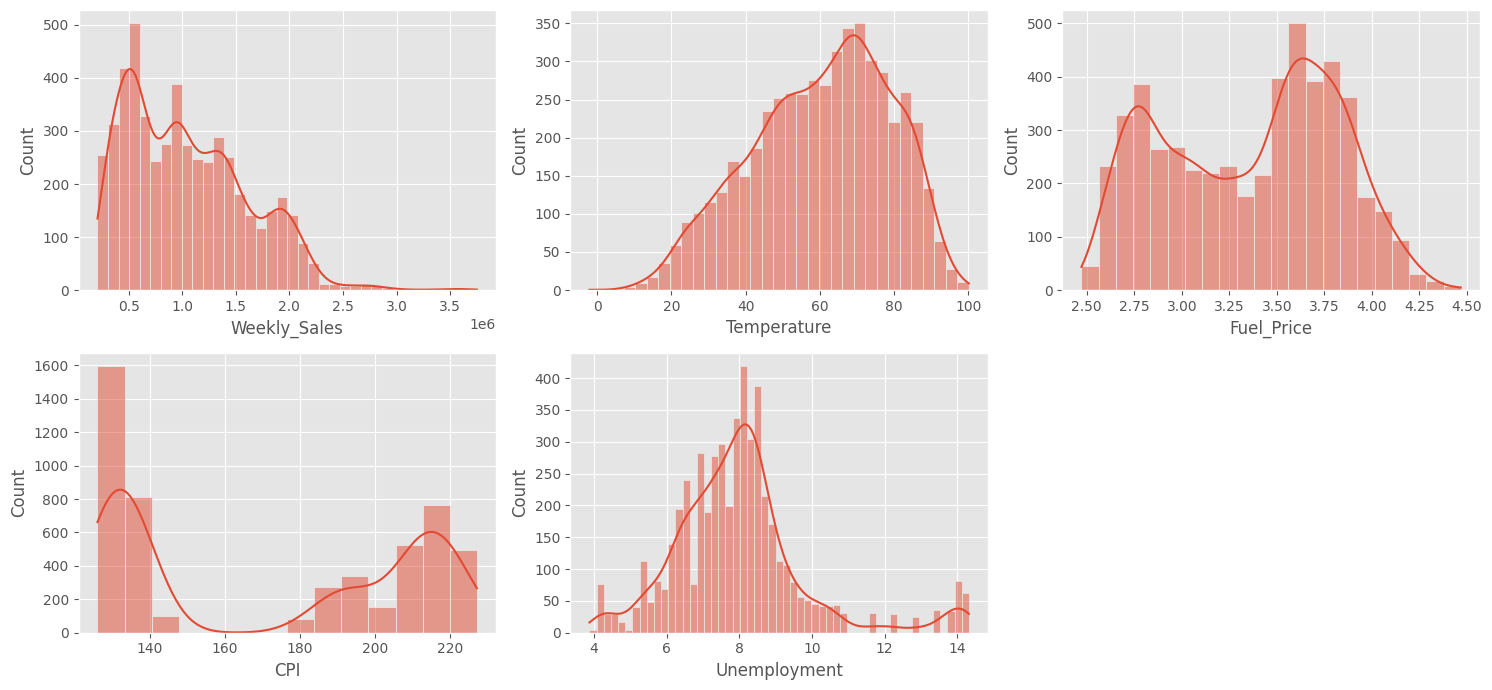

In [161]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
sns.histplot(data=train, x='Weekly_Sales', kde=True, ax=axes[0, 0])
sns.histplot(data=train, x='Temperature', kde=True, ax=axes[0, 1])
sns.histplot(data=train, x='Fuel_Price', kde=True, ax=axes[0, 2])
sns.histplot(data=train, x='CPI', kde=True, ax=axes[1, 0])
sns.histplot(data=train, x='Unemployment', kde=True, ax=axes[1, 1])
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

Some interesting points looking at the plot above:
1. A large part of the stores make about 500000, 1000000 and 1500000 dollars of weekly sales.
2. Most of the temperatures are about 70 fahrenheint degrees.
3. Unemployment rate is commonly around 8.
4. Most of the CPI are less than 140.
5. 2.50-2.75 and 3.50-3.75 are common fuel prices.

#### Outliers check and visualization

In [162]:
outlier_positions, outlier_counts, total_outliers = check_outliers(train, train.drop(columns=['Store', 'Date', 'Holiday_Flag']).columns.to_list())

print(f'Number (percentage) of outliers per feature: ')
print()
for feature, count in outlier_counts.items():
    print(f'{feature}: {count} ({round(count/len(df)*100, 2)})%')

Number (percentage) of outliers per feature: 

Weekly_Sales: 31 (0.48)%
Temperature: 1 (0.02)%
Fuel_Price: 0 (0.0)%
CPI: 0 (0.0)%
Unemployment: 378 (5.87)%


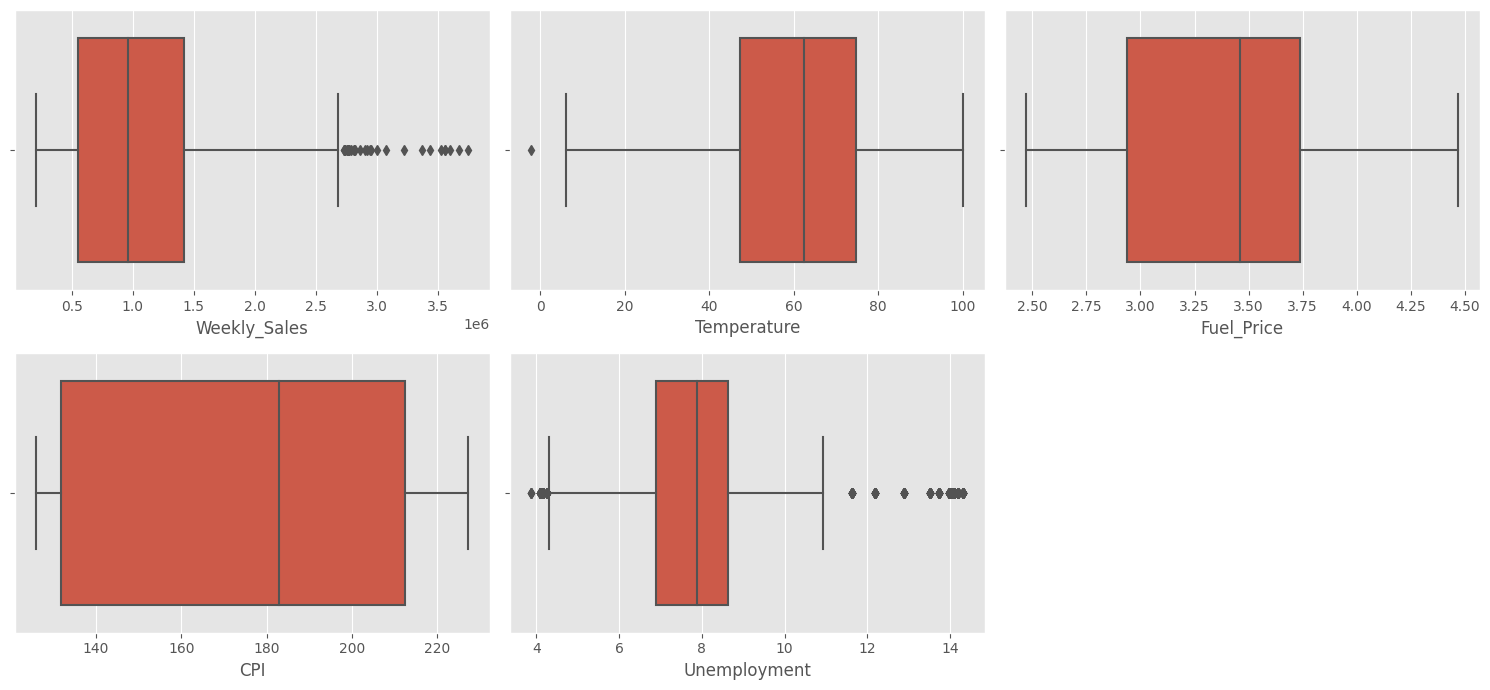

In [163]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
sns.boxplot(data=train, x='Weekly_Sales', ax=axes[0, 0])
sns.boxplot(data=train, x='Temperature', ax=axes[0, 1])
sns.boxplot(data=train, x='Fuel_Price', ax=axes[0, 2])
sns.boxplot(data=train, x='CPI', ax=axes[1, 0])
sns.boxplot(data=train, x='Unemployment', ax=axes[1, 1])
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

There are a lot of outliers in Weekly_Sales and Unemployment. However, they're not due to measurement errors. Some stores make more sales and some regions have larger or lower unemployment rates. Thus, I will just drop the Temperature outlier further because the other ones might represent valuable information for the model. Moreover, because I have a little amount of data, it is not interesting to drop records.

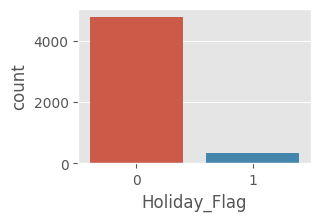

In [164]:
plt.figure(figsize=(3, 2))
sns.countplot(data=train, x='Holiday_Flag')
plt.show()

### Bivariate and multivariate analysis

In [165]:
# Getting pearson correlation matrix
corr_matrix = train.corr()

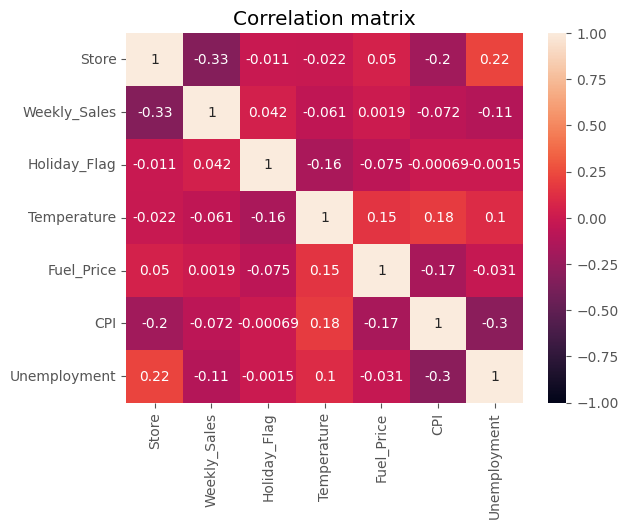

In [166]:
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

Apparently, there is no multicolinearity between the features. To make sure of this, it would be necessary to asses the variance inflation factor of the variables. However, as there are just some weak correlations, I will not do it. Furthermore, weekly_sales is not significantly correlated with any other feature. There is just a moderate negative correlation between it and Store, but I can't take conclusions about it now. The same for the other variables, there are just a few weak correlations.

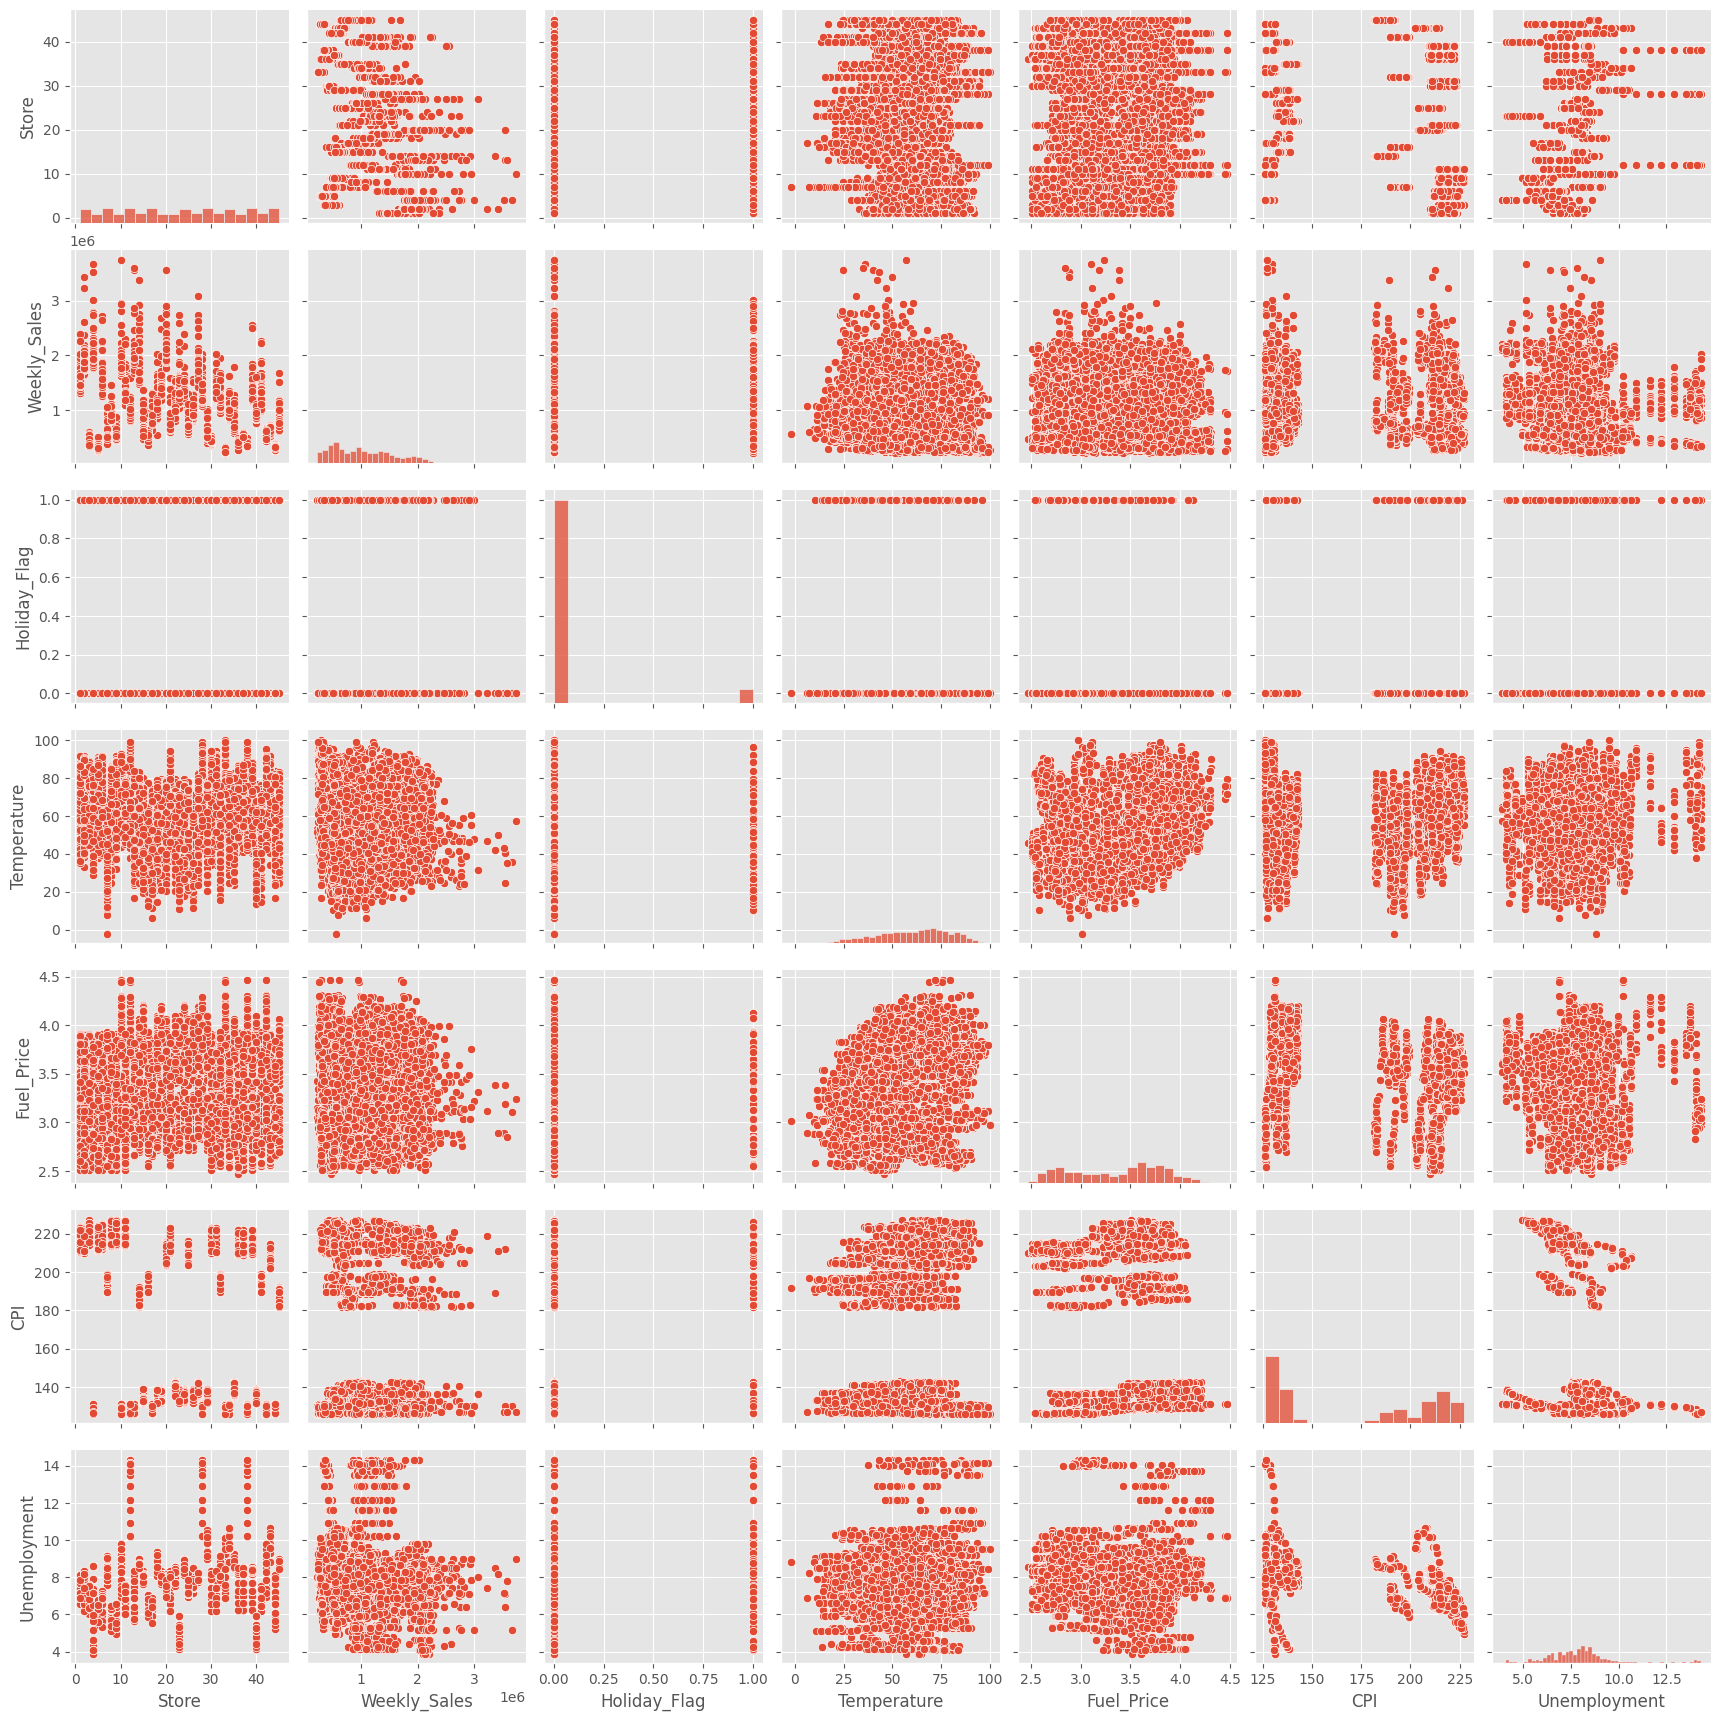

In [167]:
sns.pairplot(data=train)
plt.show()

There isn't any significant linear relationship, reinforcing the conclusions looking at the correlation matrix. Moreover, considering this, tree-based models might perform better than linear models.

Let's check the individual stores average weekly sales.

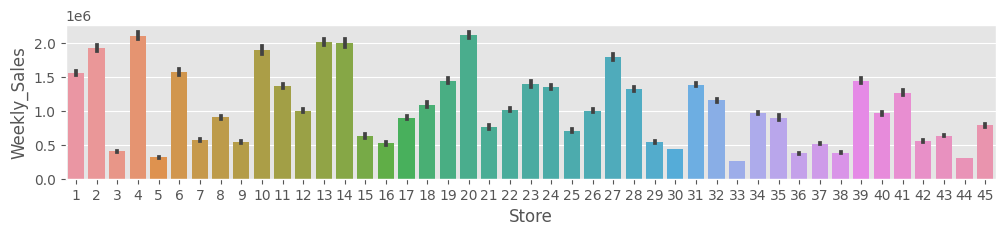

In [168]:
plt.figure(figsize=(12, 2))
sns.barplot(data=train, x='Store', y='Weekly_Sales')
plt.show()

Stores 4 and 20 are the best ones.

Let's look at how holidays affect weekly sales.

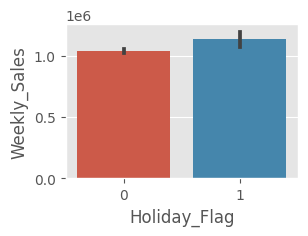

In [169]:
plt.figure(figsize=(3, 2))
sns.barplot(data=train, x='Holiday_Flag', y='Weekly_Sales')
plt.show()

In [170]:
# How the holidays affect weekly sales.
train.groupby(['Holiday_Flag'])['Weekly_Sales'].mean()

Holiday_Flag
0    1.038621e+06
1    1.133477e+06
Name: Weekly_Sales, dtype: float64

In [171]:
train_holiday = train.loc[train['Holiday_Flag'] == 1]

print(f'Total number of holiday special weeks: {len(train_holiday)}')
print('Unique holiday special weeks:', train_holiday['Date'].nunique())
print(train_holiday['Date'].unique())

Total number of holiday special weeks: 346
Unique holiday special weeks: 10
['26-11-2010' '31-12-2010' '25-11-2011' '30-12-2011' '07-09-2012'
 '09-09-2011' '11-02-2011' '10-09-2010' '10-02-2012' '12-02-2010']


In [172]:
train_not_holiday = train.loc[train['Holiday_Flag'] == 0]
print('Unique normal weeks:', train_not_holiday['Date'].nunique())

Unique normal weeks: 133


As expected, special holiday weeks sales are greater than normal ones. Moreover, for training data, there are 10 different holiday special weeks and 133 normal weeks.

In [173]:
# Looking at each holiday impact on weekly sales. 
super_bowl = ['12-02-2010', '11-02-2011', '10-02-2012', '08-02-2013']
labour_day = ['10-09-2010', '09-09-2011', '07-09-2012', '06-09-2013']
thanksgiving = ['26-11-2010', '25-11-2011', '23-11-2012', '29-11-2013']
christmas = ['31-12-2010', '30-12-2011', '28-12-2012', '27-12-2013']

In [174]:
# Defining a function to identify the holiday.
def which_holiday(x):
    if x in set(super_bowl):
        x = 'Super bowl'
    elif x in set(labour_day):
        x = 'Labour day'
    elif x in set(thanksgiving):
        x = 'Thanksgiving'
    else:
        x = 'Christmas'
    return x

In [175]:
# Creating the new column identifying which holiday is by applying the function above.
train_holiday['Holiday'] = train_holiday['Date'].apply(which_holiday)
print('Holidays: ', train_holiday['Holiday'].nunique())
print(train_holiday['Holiday'].unique())
print(train_holiday['Holiday'].value_counts())

Holidays:  4
['Thanksgiving' 'Christmas' 'Labour day' 'Super bowl']
Super bowl      102
Labour day      100
Thanksgiving     75
Christmas        69
Name: Holiday, dtype: int64


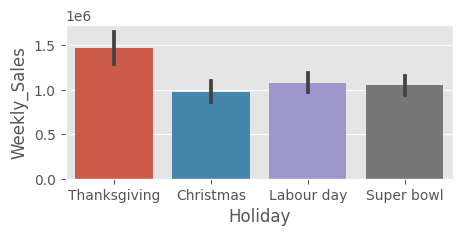

In [176]:
# Analysing the impact of each holiday on weekly sales.
plt.figure(figsize=(5, 2))
sns.barplot(data=train_holiday, x='Holiday', y='Weekly_Sales')
plt.show()

Clearly, weekly sales are higher during Thanksgiving. Furthermore, sales are lower during Christmas. This may occur because people tend to make purchases a week or more before the Christmas holiday, while in Thanksgiving week, there is Black Friday.

In [177]:
# Converting Date column to datetime data type for plotting the line graph below.
train['Date'] = pd.to_datetime(train['Date'])
train['Date'].dtype

dtype('<M8[ns]')

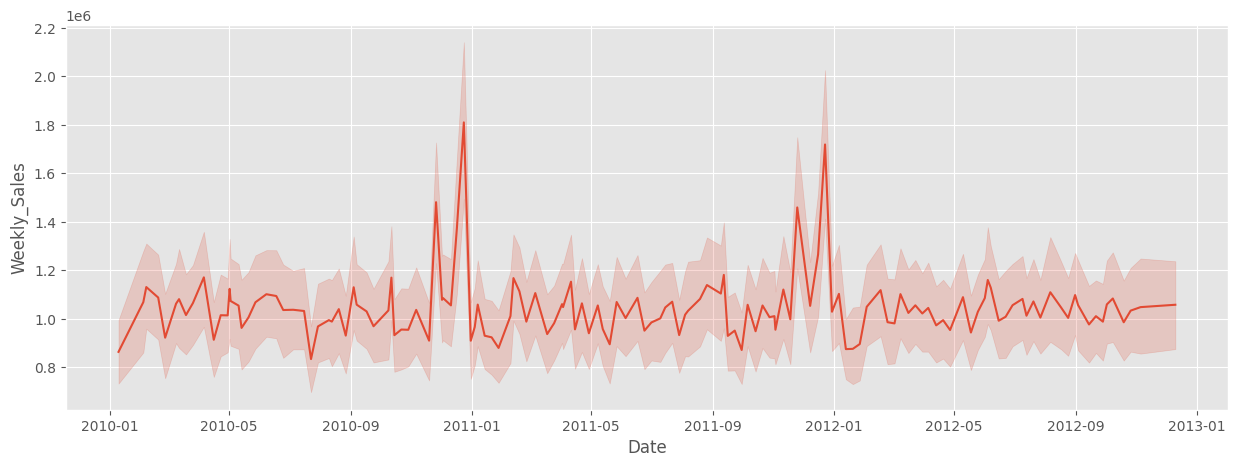

In [178]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='Date', y='Weekly_Sales')
plt.show()

Clearly, from november to december the weekly sales are greater. I will look into it deeply below.

In [179]:
# Creating a month column.
train['Month'] = train['Date'].dt.month
# Creating a year column.
train['Year'] = train['Date'].dt.year
# Creating a week column.
train['Week'] = train['Date'].dt.week

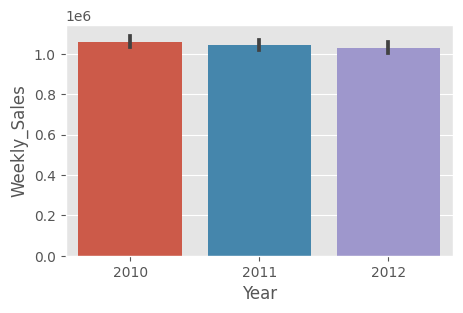

In [180]:
# Plotting the weekly sales per year to see the best years for sales.
plt.figure(figsize=(5, 3))
sns.barplot(data=train, x='Year', y='Weekly_Sales')
plt.show()

The weekly sales are similar in the different years.

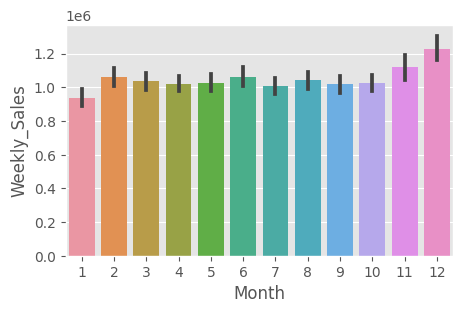

In [181]:
# Plotting the weekly sales per month to see the best months for sales.
plt.figure(figsize=(5, 3))
sns.barplot(data=train, x='Month', y='Weekly_Sales')
plt.show()

November and December are the best months for sales. Furthermore, January is the worst month for sales. This may occur because people spend more money during the sales in November and December, saving money in January.

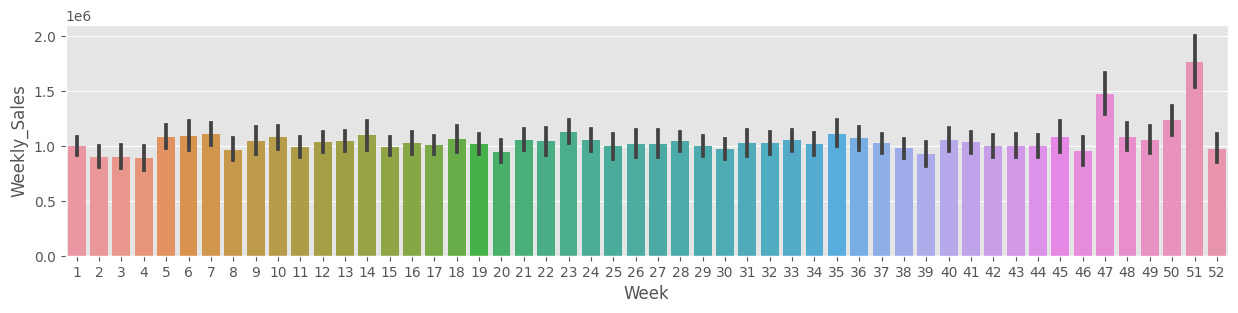

In [182]:
# Plotting the weekly sales per week to see the best weeks for sales.
plt.figure(figsize=(15, 3))
sns.barplot(data=train, x='Week', y='Weekly_Sales')
plt.show()

51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

# 5. Data cleaning and preprocessing
- There are some transformations we need to apply to the data in order to fit machine learning algorithms.
- I intend to test different algorithms. For tree-based models, like decision trees, LightGBM, and random forests, it is not necessary to scale the data, so, I won't need to apply any preprocessing. However, for linear models like linear regression, it is necessary to scale the data, so I will apply Standard Scaler (subtract the mean and divide by the standard deviation).
- There are not categorical features in the data, so it is not necessary to encode any.
- There are not missing values in the data, so it is not necessary to treat any.
- I will remove the outlier from Temperature because it is the unique value on that range of temperatures below the lower limit.

In [183]:
# Creating a new dataset for cleaning.
# I will drop the Date column because I have already created separate Year, Month, and Week columns that describe the Date.
clean_train = train.drop(columns=['Date'])

In [184]:
clean_train.isna().sum()

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Month           0
Year            0
Week            0
dtype: int64

Dropping the temperature outlier.

In [185]:
clean_train.drop(clean_train.loc[clean_train['Temperature'] < 0].index, inplace=True)

In [186]:
clean_train.loc[clean_train['Temperature'] < 0]

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year,Week


In [187]:
# Separating into predictor and target variable.
X_train = clean_train.drop(columns=['Weekly_Sales'])
y_train = clean_train['Weekly_Sales'].copy()
X_train.shape, y_train.shape

((5147, 9), (5147,))

In [188]:
# Preparing the data for tree-based models, it is not necessary to apply any preprocessing technique.
X_train_prepared_tree_models = X_train.copy()

In [189]:
#Preparing the data for linear models, it is necessary to scale the data.
std_scaler = StandardScaler()

X_train_prepared_linear_models = std_scaler.fit_transform(X_train)
X_train_prepared_linear_models

array([[-1.16496846, -0.26845543,  0.80593942, ...,  0.76947335,
        -1.22563497,  0.76650606],
       [-1.24196286, -0.26845543, -2.15392917, ...,  1.37191925,
         0.03251086,  1.24905799],
       [ 1.45284105, -0.26845543,  0.04294144, ...,  1.67314221,
        -1.22563497,  1.59373794],
       ...,
       [ 1.06786906, -0.26845543,  1.42316577, ..., -0.43541845,
         0.03251086, -0.54327774],
       [ 1.14486346,  3.72501309, -0.85661584, ...,  1.67314221,
         0.03251086,  1.80054591],
       [-1.24196286, -0.26845543, -1.79735767, ..., -1.3390873 ,
        -1.22563497, -1.30157363]])

# 6. Model training, comparison, selection and tuning
- In this step, I intend to compare different models performances. In order to achieve this, I will use k-fold cross validation to train each one of them. Furthermore, I will use mean squared error as my metric for performance evaluation.
- <b>K-fold cross-validation</b> is a technique used in machine learning to assess the performance of a model. It involves splitting the data into k equally sized subsets or folds. The model is then trained and evaluated k times, with each fold serving as the test set once while the remaining folds are used as the training set. The performance metrics from each iteration are averaged to provide an overall estimation of the model's performance.
- <b>We use k-fold cross-validation to:</b><br>
    <b>1.</b> Obtain a more reliable estimate of the model's performance by reducing the impact of data variability.<br>
    <b>2.</b> Assess the model's generalization ability by evaluating its performance on multiple independent datasets.<br>
    <b>3.</b> Ensure that the model is not overfitting or underfitting by evaluating its performance on different subsets of the data.<br>
    <b>4.</b> Facilitate hyperparameter tuning by comparing the performance of different parameter configurations.<br>
    <b>5.</b> Provide a more robust evaluation metric that helps in making informed decisions about the model's effectiveness and        suitability for deployment.<br>
- After selecting a model, I will tune its hyperparameters.
<br>
- <b>Hyperparameter tuning</b> refers to the process of selecting the optimal hyperparameters for a machine learning model. Hyperparameters are parameters that are set before the model is trained and directly influence its performance but are not learned from the data.

- <b>In hyperparameter tuning:</b><br>
    <b>1.</b> Different combinations of hyperparameters are tested to find the best configuration that maximizes the model's performance.<br>
    <b>2.</b> Techniques like grid search, random search, or Bayesian optimization are used to explore the hyperparameter space efficiently.<br>
    <b>3.</b> The goal is to find the hyperparameter values that lead to the best generalization and minimize overfitting.<br>
    <b>4.</b> Tuning hyperparameters can improve the model's accuracy, robustness, and ability to handle different datasets.<br>
    <b>5.</b> It requires a balance between computational resources, time, and the desired level of performance improvement.<br>

<b>Linear Regression</b>
- <b>Pros:</b> Simplicity and interpretability, quick computation, foundation for more complex models.<br>
- <b>Cons:</b> Limited complexity, sensitive to outliers, assumption dependencies.<br>

<b>Linear regression assumptions:</b><br>

1. Linearity
2. Independence
3. Homoscedasticity
4. Normality of residuals
5. No perfect multicollinearity

However, as I intend to find a model with the greatest predictive power, I didn't apply any transformation or search for these assumptions in the data.

In [190]:
# Instanciate and evaluate model - train score and k-fold cross validation score.
lin_reg = LinearRegression()
lin_reg_train_score, lin_reg_val_score = evaluate_model_cv(lin_reg, X_train_prepared_linear_models, y_train)

LinearRegression results:
**************************************************
Training Score:  -271430105922.66238
Average validation score: -272304231961.6961
Standard deviation: 9888439808.451323


Linear regression is not performing well. As I saw, the data doesn't have linear relationships, and a regularized linear model would introduce bias into a model that already has high bias and high variance (underfitting). Therefore, I will not even try them.

<b>Support Vector Machines</b>
- <b>Pros:</b> Effective in high-dimensional spaces, robust to overfitting, versatile kernels, works well with small datasets, global optimality.<br>
- <b>Cons:</b> Computationally expensive, sensitivity to hyperparameters, difficult to interpret, memory intensive, lack of probabilistic outputs.

I'll start evaluating LinearSVR performance, as it is faster than SVR. However, SVR will probably perform better.

In [191]:
# Instanciate and evaluate model - train score and k-fold cross validation score.
lin_svr = LinearSVR()
lin_svr_train_score, lin_svr_val_score = evaluate_model_cv(lin_svr, X_train_prepared_linear_models, y_train)

LinearSVR results:
**************************************************
Training Score:  -1399016404890.067
Average validation score: -1401167808255.5315
Standard deviation: 17446919180.295135


In [192]:
# Instanciate and evaluate model - train score and k-fold cross validation score.
svr = SVR()
svr_train_score, svr_val_score = evaluate_model_cv(svr, X_train_prepared_linear_models, y_train)

SVR results:
**************************************************
Training Score:  -324875978513.0931
Average validation score: -324959022912.7887
Standard deviation: 11745656675.896421


<b>Random Forest</b><br>
- <b>Pros:</b> High Accuracy, robustness to outliers, feature importance, handles high-dimensional data, nonlinear relationships.<br>
- <b>Cons:</b> Model interpretability, computational complexity, memory Usage, bias towards features with high cardinality, hyperparameter tuning.

In [193]:
# Instanciate and evaluate model - train score and k-fold cross validation score.
rf_reg = RandomForestRegressor()
rf_reg_train_score, rf_reg_val_score = evaluate_model_cv(rf_reg, X_train_prepared_tree_models, y_train)

RandomForestRegressor results:
**************************************************
Training Score:  -2141319626.5577765
Average validation score: -16671579428.635126
Standard deviation: 1364896853.0394895


<b>LightGBM</b>
- <b>Pros:</b> Fast and efficient, highly scalable, optimized for speed, lower memory usage, accurate and powerful, support for GPU acceleration, flexible and customizable<br>
- <b>Cons:</b> Prone to overfitting, lack of interpretability, complexity of hyperparameter tuning<br>

In [194]:
# Instanciate and evaluate model - train score and k-fold cross validation score.
lgb_reg = LGBMRegressor()
lgb_reg_train_score, lgb_reg_val_score = evaluate_model_cv(lgb_reg, X_train_prepared_tree_models, y_train)

LGBMRegressor results:
**************************************************
Training Score:  -4991663894.363227
Average validation score: -9688878854.022629
Standard deviation: 938476721.1657811


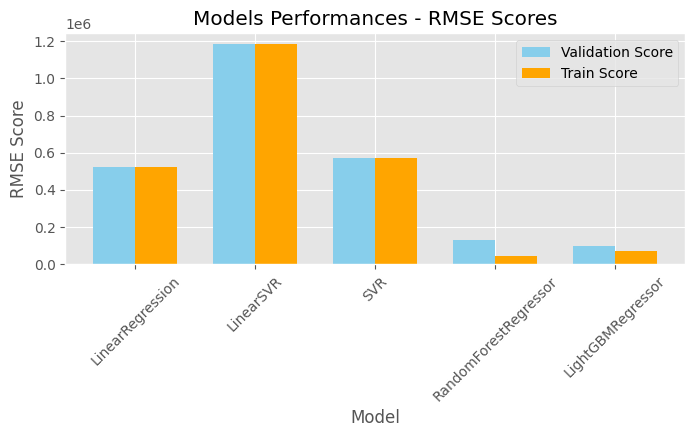

In [195]:
val_scores = {
    'LinearRegression': np.sqrt(-1 * lin_reg_val_score),
    'LinearSVR': np.sqrt(-1 * lin_svr_val_score),
    'SVR': np.sqrt(-1 * svr_val_score),
    'RandomForestRegressor': np.sqrt(-1 * rf_reg_val_score),
    'LightGBMRegressor': np.sqrt(-1 * lgb_reg_val_score)
}


train_scores = {
    'LinearRegression': np.sqrt(-1 * lin_reg_train_score),
    'LinearSVR': np.sqrt(-1 * lin_svr_train_score),
    'SVR': np.sqrt(-1 * svr_train_score),
    'RandomForestRegressor': np.sqrt(-1 * rf_reg_train_score),
    'LightGBMRegressor': np.sqrt(-1 * lgb_reg_train_score)
}

eval_df = plot_models_scores_cv(val_scores, train_scores)

In [196]:
# Dataframe with each model train score and validation (average) score.
eval_df

,Model,Val_Score,Train_Score
0,LinearRegression,5.218278e+05,5.209895e+05
1,LinearSVR,1.183709e+06,1.182800e+06
2,SVR,5.700518e+05,5.699789e+05
3,RandomForestRegressor,1.291185e+05,4.627439e+04
4,LightGBMRegressor,9.843210e+04,7.065171e+04


As expected, LightGBM and RandomForest are performing quite better than the linear models. RandomForest seems to be overfitting too much. So, I'll stick with LightGBM to tune its hyperparameters and further improve its performance. Moreover, it seems that the training error is significantly lower than the validation error, also indicating overfitting, but less than RandomForest. However, this was anticipated since I have only a limited amount of data and a complex tree-based model like LightGBM. Thus, I will choose the best Bayesian search-optimized solution, whether it is regularized or not, to get a good final result. Ideally, more data should be collected.

### Hyperparameter tuning
As I intend to tune LightGBM model, I won't use GridSearchCV.

<b>Why not use grid search?</b> 
- Using grid search CV to tune LightGBM can be problematic due to its computational expense, limitations in granularity and adaptability, lack of consideration for interaction effects, inefficient exploration of the hyperparameter space, and inefficient allocation of computational resources. 
- Grid search exhaustively searches through all combinations of specified hyperparameters, it does not adapt its search based on the observed performance of previous hyperparameter configurations. Also, hyperparameters in LightGBM can have complex interactions, where the impact of one hyperparameter depends on the values of others (like learning rate and number of estimators). Grid search does not explicitly consider these interactions and evaluates hyperparameters independently. 
- As a result, more advanced optimization methods such as randomized search and Bayesian Optimization are often preferred for more efficient and effective hyperparameter tuning with LightGBM.<br>

Considering this, I will tune LightGBM using Bayesian Optimization.

<b>What is Bayesian Optimization?</b>
-  Bayesian optimization is an efficient and adaptive technique for finding the optimal combination of hyperparameters for a machine learning model. It uses probabilistic models to intelligently explore the hyperparameter space, balancing exploration and exploitation.

In [197]:
# When tuning learning rate hyperparameter, we're more interested in lower values of it - more stability. 
# Log-uniform distribution will give larger weight to lower values of learning rate hyperparameter.

search_space = {
    'learning_rate': Real(0.01, 1, prior='log-uniform'),
    'num_leaves': Integer(2, 128),
    'min_child_samples': Integer(1, 100),
    'min_split_gain': Real(0.0, 1),
    'reg_lambda': Real(0.0, 10), 
    'subsample': Real(0.05, 1),
    'colsample_bytree': Real(0.1, 1)
}

bayesian_search = BayesSearchCV(LGBMRegressor(), search_space, cv=5, n_iter=50, scoring='neg_mean_squared_error', return_train_score=True, random_state=42) 

In [198]:
bayesian_search.fit(X_train_prepared_tree_models, y_train, )

BayesSearchCV(cv=5, estimator=LGBMRegressor(), random_state=42,
              return_train_score=True, scoring='neg_mean_squared_error',
              search_spaces={'colsample_bytree': Real(low=0.1, high=1, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=1, prior='log-uniform', transform='normalize'),
                             'min_child_samples': Integer(low=1, high=100, prior='uniform', transform='normalize'),
                             'min_split_gain': Real(low=0.0, high=1, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=2, high=128, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0, high=10, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.05, high=1, prior='uniform', transform='normalize')})

In [199]:
print(f'The best params found for LightGBM are: ')
bayesian_search.best_params_

The best params found for LightGBM are: 


OrderedDict([('colsample_bytree', 0.767897755958507),
             ('learning_rate', 0.25900205562097967),
             ('min_child_samples', 1),
             ('min_split_gain', 0.4218941450917342),
             ('num_leaves', 52),
             ('reg_lambda', 0.36816104315289644),
             ('subsample', 0.42979635585739423)])

Let's take a look into some results obtained by the bayesian search cv, specially for important parameters, like learning_rate, min_child_samples, num_leaves and reg_lambda.

In [200]:
bayesian_search_results = pd.DataFrame(bayesian_search.cv_results_)
bayesian_search_results = bayesian_search_results[['rank_test_score','mean_test_score',
                                                   'mean_train_score', 'param_learning_rate', 
                                                   'param_num_leaves', 'param_min_child_samples',
                                                   'param_reg_lambda']]
bayesian_search_results.sort_values(['rank_test_score'], inplace=True)
bayesian_search_results.head(10)

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_num_leaves,param_min_child_samples,param_reg_lambda
39,1,-8.430266e+09,-5.530406e+08,0.259002,52,1,0.368161
38,2,-8.511937e+09,-4.628572e+08,0.25763,50,1,0.0
37,3,-8.558353e+09,-6.045545e+08,0.258369,50,1,0.086862
49,4,-8.715734e+09,-6.932771e+08,0.302519,49,1,2.161502
47,5,-8.776618e+09,-1.573716e+09,0.260077,34,1,4.621453
42,6,-8.974064e+09,-5.169953e+08,0.26256,50,1,0.0
33,7,-9.002142e+09,-2.154953e+09,0.261388,32,12,3.364105
19,8,-9.193041e+09,-1.960584e+09,0.262234,33,8,4.210575
20,9,-9.194190e+09,-6.217503e+08,0.386679,52,1,5.688712
24,10,-9.239936e+09,-1.979551e+09,0.232284,33,1,6.318685


# 7. Final production model testing and evaluation
- In this final step, I intend to evaluate the tuned final model on test data (simulating production unseen data).
- The tuned final model will be evaluated first with regard to a baseline in order to assess the worthiness of using machine learning to solve this problem. Then, it will be evaluated with regard to the default model without tuning to assess the balance between performance improvement and computational cost. Finally, it will be evaluated in more detail after making sure this is the best final solution.
- As I'm dealing with a regression problem, I will take a look at a bunch of metrics.
- Some important metrics are root mean squared error (RMSE), mean squared error (MSE), mean absolute error (MAE) and R2, which I will detail below.

In [201]:
# Getting the final tuned LightGBM regressor model.
final_lgb_reg = bayesian_search.best_estimator_

I will apply the same preprocessing pipeline for test set. An important note is to apply only transform (if necessary), in order to avoid data leakage.

In [202]:
test.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
2436,18,12-03-2010,1138800.32,0,42.39,2.805,131.784000,9.202
3361,24,24-06-2011,1304850.67,0,68.88,3.964,135.265267,8.212
233,2,28-10-2011,1769296.25,0,65.87,3.372,217.325182,7.441
3667,26,11-11-2011,1077640.13,0,40.08,3.570,136.461806,7.598
5011,36,19-03-2010,428851.99,0,59.56,2.701,209.980321,8.554


In [203]:
# Converting Date into datetime data type.
test['Date'] = pd.to_datetime(test['Date'])
# Adding the same new columns added in train before.
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Week'] = test['Date'].dt.week

In [204]:
# Test set does not have outliers below the lower limit of IQR method for Temperature.
test.loc[test['Temperature'] < 0]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week


In [205]:
# Dropping Date column.
test.drop(columns=['Date'], inplace=True)

In [206]:
# Dividing test set into predictor (X) and target (y) features.
X_test = test.drop(columns=['Weekly_Sales'])
y_test = test['Weekly_Sales'].copy()
X_test.shape, y_test.shape

((1287, 9), (1287,))

In [207]:
# For tree based models, it wasn't necessary to apply any preprocessing step, as they don't require feature scaling.
X_test_prepared_tree_models = X_test.copy()

In [208]:
# Predicting.
final_predictions = final_lgb_reg.predict(X_test_prepared_tree_models)

In [209]:
# Compare predicted and actual values.
compare_predicted_actual = pd.DataFrame({'Actual': np.round(y_test, 2),
                                        'Predicted': np.round(final_predictions, 2), 'Residual': np.round(np.abs(final_predictions - y_test), 2)})
compare_predicted_actual.sample(15, random_state=42).reset_index(drop=True)

,Actual,Predicted,Residual
0,329613.20,382212.62,52599.42
1,1146992.13,1363862.75,216870.62
2,651837.77,604564.69,47273.08
3,2152229.11,2149241.74,2987.37
4,1220815.33,1403448.86,182633.53
5,237129.81,230371.20,6758.61
6,1323999.36,1445708.70,121709.34
7,1078182.18,1173749.05,95566.87
8,1525147.09,1524327.61,819.48
9,1539930.50,1586120.56,46190.06


### Baseline solution
Before evaluating final LightGBMRegressor model, it is important to define a naive baseline for our solution, such that if the machine learning model we have built does't outperform it, then more data is necessary, ML algorithms are not a proper solution for the problem or it can be solved 
with a simpler solution. For a supervised learning regression task, a good naive baseline solution is to predict the 
train target median value for each test instance. Then, I will evaluate this baseline prediction with root mean squared error
RMSE, which is defined in more detail below in the model evaluation step.

In [210]:
# Defining a function to evaluate the baseline solution with RMSE.
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

In [211]:
# Baseline.
baseline = train['Weekly_Sales'].median()

print(f'Baseline: {baseline}.')
print(f'Baseline performance on test set: RMSE = {round(rmse(y_test, baseline), 2)}')

Baseline: 959052.23.
Baseline performance on test set: RMSE = 575612.39


### Comparing the default LightGBM model and the tuned one on test set.
I will compare the default LightGBM model and the tuned one on the test set to observe the performance improvement provided by hyperparameter tuning. Moreover, I will compare the training times of both default and tuned models to assess the balance between computational cost and performance gain. In machine learning, many tasks involve trade-offs, such as bias-variance, precision-recall, etc. This time won't be an exception.

In [212]:
# Default and tuned models.
default_model = LGBMRegressor()
tuned_model = clone(final_lgb_reg)

In [213]:
# Fitting default model and measuring training time.
start_time = time.time()
default_model.fit(X_train_prepared_tree_models, y_train)
end_time = time.time()
default_training_time = end_time - start_time

print(f'Default model training time: {round(default_training_time, 5)} seconds.')

Default model training time: 0.06474 seconds.


In [214]:
# Fitting tuned model and measuring training time.
start_time = time.time()
tuned_model.fit(X_train_prepared_tree_models, y_train)
end_time = time.time()
tuned_training_time = end_time - start_time

print(f'Tuned model training time: {round(tuned_training_time, 5)} seconds.')

Tuned model training time: 0.08791 seconds.


In [215]:
print(f'The tuned model is approximately {round(tuned_training_time / default_training_time, 2)} times slower than default model.')

The tuned model is approximately 1.36 times slower than default model.


In [216]:
# Comparing default and tuned model performances.
default_predictions = default_model.predict(X_test)
tuned_predictions = tuned_model.predict(X_test)

default_rmse = np.sqrt(mean_squared_error(y_test, default_predictions))
tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_predictions))

print(f'Default model RMSE: {round(default_rmse, 2)}')
print(f'Tuned model RMSE: {round(tuned_rmse, 2)}')
print(f'Tuned model has improved default model performance by approximately {round((default_rmse - tuned_rmse) / (default_rmse) * 100, 2)}%.')

Default model RMSE: 136665.43
Tuned model RMSE: 123857.58
Tuned model has improved default model performance by approximately 9.37%.


The baseline was significantly outperformed! Machine learning is indeed suitable and valuable for predicting weekly sales. Furthermore, the tuned model improved the performance of the default one by approximately 9.37%, very good!. Thus, considering it takes less than 1 second to be trained and is just 1.36 times slower than the default model, it is worth going with the tuned LightGBM.

### Final LightGBM model evaluation

### Regression evaluation metrics

<b>Given:</b><br>
- <b>n:</b> the number of data points (samples)<br>
- <b>yᵢ:</b> the observed (actual) value of the target variable for the i-th data point<br>
- <b>ȳ:</b> the mean of the observed target values (sum of yᵢ divided by n)<br>
- <b>ȳᵢ:</b> the predicted value of the target variable for the i-th data point (output of the regression model)<br>

<b>1. Mean Absolute Error (MAE)</b>
- The MAE is the average absolute difference between the observed and predicted values. It measures the average magnitude of     errors without considering their direction (positive or negative).
- Formula: <b>MAE = (1/n) * ∑|yᵢ - ȳᵢ|</b><br>

<b>2. Mean Squared Error (MSE)</b>
- The MSE is the average of the squared differences between the observed and predicted values. It penalizes larger errors more than smaller ones due to the squaring operation.
- Formula: <b>MSE = (1/n) * ∑(yᵢ - ȳᵢ)²</b><br>

<b>3. Root Mean Squared Error (RMSE)</b>
- The RMSE is the square root of the MSE. It is often used because it has the same unit as the target variable and is interpretable in the original scale of the data.
- Formula: <b>RMSE = √(MSE)</b><br>

<b>4. R-squared (R2)</b> 
- R-Squared is a statistical metric used to measure the proportion of variance in the dependent variable explained by the independent variable(s). It ranges from 0 to 1, where 0 indicates the model does not explain any variance, and 1 indicates a perfect fit. R2 is commonly used to assess the goodness of fit of a regression model.

Mean Absolute Error (MAE): 82155.69
Mean Squared Error (MSE): 15340700265.16
Root Mean Squared Error (RMSE): 123857.58
R-Squared (R2): 0.95


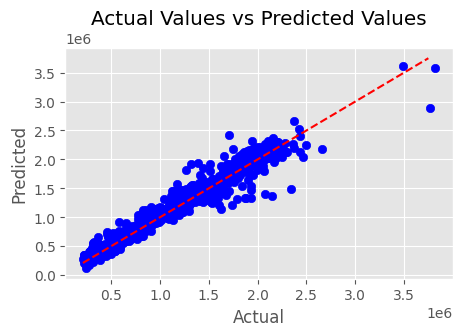

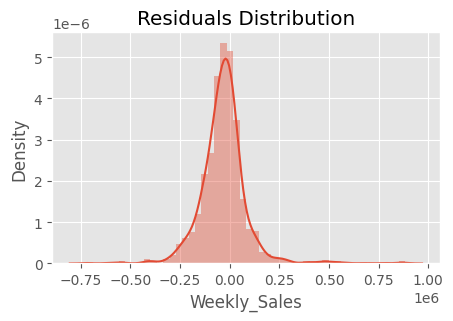

In [217]:
evaluate_regressor(y_test, final_predictions, y_train)

1. <b>RMSE</b> tells us explicitly how much our predictions deviate, on average, from the actual values in the dataset. In this case, our predicted values are around 123,857 dollars away from the actual value, which indicates a good generalization error and model performance, considering an average weekly sales of 1,055,000 dollars.
2. <b>R-squared (R2)</b> is a statistical metric used to measure the proportion of variance in the dependent variable explained by the independent variable(s). It ranges from 0 to 1, where 0 indicates the model does not explain any variance, and 1 indicates a perfect fit. R2 is commonly used to assess the goodness of fit of a regression model. According to the R-squared, 95% of the variance in the dependent variable is explained by the model. Very good!
3. The <b>residuals</b> seem to be approximately normally distributed and their variance is almost constant. These are some of the linear regression assumptions.

### Interpreting model results with feature importances

Finally, I will look at <b>feature importances</b>, in order to interpret LightGBM outcomes, perform some feature selection and see if the model results improve or not. An important task when performing supervised learning on a dataset is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do.

LightGBM calculates feature importances by using the "split" value, which represents the number of times a feature is used to split data across all trees, weighted by the number of samples in each split. It then normalizes the importance scores by the sum of all split values and scales them to a range of [0, 1]. Higher normalized values indicate more important features.

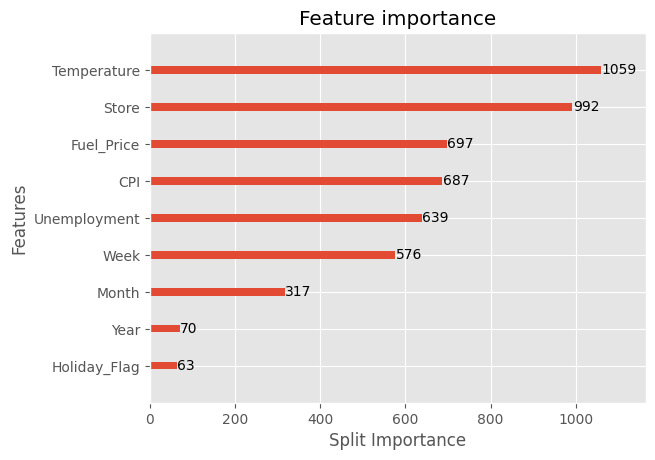

In [218]:
plot_importance(final_lgb_reg, max_num_features=10, importance_type='split', xlabel='Split Importance', ylabel='Features');

Surprisingly, Holiday_Flag is the less important feature in predicting weekly sales. Furthermore, I will perform feature selection by dropping Holiday_Flag, Year and Month columns in order to improve the model performance, keeping the features with split importances higher than 500.

### Model after performing feature selection

In [219]:
# Getting new predictor and target train and test sets dropping the columns with less than 1000 LightGBM feature importance score.
X_train_selected = X_train.drop(columns=['Holiday_Flag', 'Year', 'Month'])
X_test_selected = X_test.drop(columns=['Holiday_Flag', 'Year', 'Month'])
X_train_selected.shape, X_test_selected.shape

((5147, 6), (1287, 6))

In [220]:
# Creating a clone of the final tuned model in order to fit it to the training data after performing feature selection. 
# Clone does a deep copy of the model in an estimator without actually copying attached data. It returns a new estimator with the same parameters that has not been fitted on any data.
final_lgb_reg_selected = clone(final_lgb_reg)

In [221]:
# Training the final model clone with training set after feature selection.
final_lgb_reg_selected.fit(X_train_selected, y_train)

LGBMRegressor(colsample_bytree=0.767897755958507,
              learning_rate=0.25900205562097967, min_child_samples=1,
              min_split_gain=0.4218941450917342, num_leaves=52,
              reg_lambda=0.36816104315289644, subsample=0.42979635585739423)

In [222]:
# Predicting with test set after feature selection.
predictions_selected = final_lgb_reg_selected.predict(X_test_selected)

In [223]:
# Evaluating predictions made by the model after performing feature selection in training and test sets.

# Compare predicted and actual values.
compare_predicted_actual_selected = pd.DataFrame({'Actual': np.round(y_test, 2),
                                        'Predicted': np.round(predictions_selected, 2), 'Residual': np.round(np.abs(predictions_selected - y_test), 2)})
compare_predicted_actual_selected.sample(15, random_state=42).reset_index(drop=True)

,Actual,Predicted,Residual
0,329613.20,315049.54,14563.66
1,1146992.13,1065751.80,81240.33
2,651837.77,752998.58,101160.81
3,2152229.11,2098711.85,53517.26
4,1220815.33,1317418.57,96603.24
5,237129.81,249488.55,12358.74
6,1323999.36,1340674.36,16675.00
7,1078182.18,1104084.60,25902.42
8,1525147.09,1547187.20,22040.11
9,1539930.50,1515490.73,24439.77


Mean Absolute Error (MAE): 54094.4
Mean Squared Error (MSE): 7943404518.03
Root Mean Squared Error (RMSE): 89125.78
R-Squared (R2): 0.98


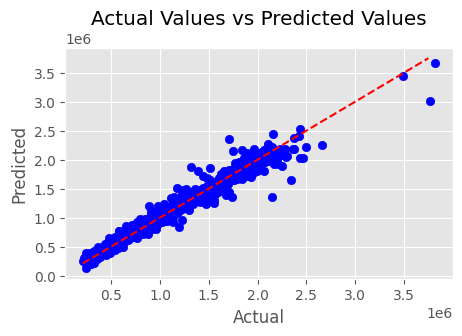

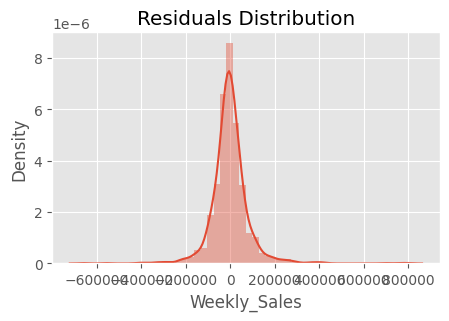

In [225]:
# Metrics and residual plots.
evaluate_regressor(y_test, predictions_selected, y_train)

Clearly, the model has improved its performance after feature selection! Our RMSE has decreased from 123,857 to 89,125, and the R2 value has increased by 3%, now reaching 98%.

1. <b>RMSE</b> tells us explicitly how much our predictions deviate, on average, from the actual values in the dataset. In this case, our predicted values are around 89,125 dollars away from the actual value, which indicates a good generalization error and model performance, considering an average weekly sales of 1,055,000 dollars.
2. <b>R-squared (R2)</b> is a statistical metric used to measure the proportion of variance in the dependent variable explained by the independent variable(s). It ranges from 0 to 1, where 0 indicates the model does not explain any variance, and 1 indicates a perfect fit. R2 is commonly used to assess the goodness of fit of a regression model. According to the R-squared, 98% of the variance in the dependent variable is explained by the model. Very good!
3. The <b>residuals</b> seem to be approximately normally distributed and their variance is almost constant. These are some of the linear regression assumptions.

# 8. Conclusions

In this project, I have built a machine learning model to predict Walmart's weekly sales with LightGBM. Thus, it was a supervised learning task using labeled training data for regression, with the target being weekly sales. Furthermore, the EDA revealed several insights, and the model's performance is quite decent. Its performance was improved after I did feature selection on the data, reaching better final results. Considering that the average weekly sales value is 1,055,000 dollars, our predicted values are approximately 89,125 dollars away from the actual sales (RMSE), providing valuable predictions. Also, approximately 98% of the variance in the dependent variable (weekly sales) is explained by the model (R-Squared). Finally, predicting sales will offer numerous benefits and useful applications for Walmart, such as inventory management, resource allocation, supply chain efficiency, promotion and pricing strategies, financial planning, competitive advantage, customer satisfaction, and waste reduction.